# Group Members:
1. Raymond Chen
2. Shreya Enaganti
3. Asad Javed
4. Mohammed Rhazi

# Exercise: AQR Momentum Strategies

## 2. Investigating Momentum

## Data
In this section, we empirically investigate some concerns regarding AQR’s new momentum product.

- The first tab contains the momentum factor as an excess return: 


- The second tab contains returns on portfolios corresponding to scored momentum deciles. denotes the portfolio of stocks in the lowest momentum decile, the “losers” with the lowest past returns denotes the portfolio of stocks in the highest momentum decile.

- The third tab gives portfolios sorted by momentum and size. denotes the portfolio of small stocks in the top 3 deciles of momentum scores. denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

## 2.1 Is Momentum still profitable?
The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2024?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as skew
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
# Load data
fn = "data/momentum_data.xlsx"
xls = pd.read_excel(fn, sheet_name=None)
sheet_names = list(xls.keys())
sheet_names

['descriptions',
 'factors (excess returns)',
 'momentum (excess returns)',
 'deciles (total returns)',
 'size_sorts (total returns)',
 'risk-free rate']

In [3]:
 # decile portfolio returns (r^mom(1) … r^mom(10))  
df_deciles = xls[sheet_names[3]].set_index("Date")

# Inspect columns
#print("Decile columns:", df_deciles.columns.tolist())

# factor returns including market and value
df_factors = xls[sheet_names[1]].set_index("Date")

# momentum factor returns (UMD)
df_momentum = xls[sheet_names[2]].set_index("Date")

# size sorts (SMB) if needed and risk-free rate
df_size_sorts = xls[sheet_names[4]].set_index('Date')
rf = xls[sheet_names[5]].set_index('Date')
df_factors['UMD'] = df_momentum['UMD']

## (a)
Using the data provided, fill in Table 1

In [4]:
# Date‐ranges
subsamples = {
    "1927-2024": ("1927-01-01", "2024-12-31"),
    "1927-1993": ("1927-01-01", "1993-12-31"),
    "1993-2008": ("1993-01-01", "2008-12-31"),
    "2009-2024": ("2009-01-01", "2024-12-31"),
}

rows = []
for label,(start,end) in subsamples.items():
    # filter
    s = df_factors.loc[start:end].dropna(subset=["UMD"])
    mean = s["UMD"].mean() *12
    sigma = s["UMD"].std() * np.sqrt(12)
    sharpe = mean / sigma
    skewness = skew.skew(s["UMD"])
    # correlation
    corr_m = s["UMD"].corr(s["MKT"])
    corr_v = s["UMD"].corr(s["HML"])
    rows.append({
        "Subsample": label,
        "Mean": mean,
        "Vol": sigma,
        "Sharpe": sharpe,
        "Skewness": skewness,
        "Corr_to_rm": corr_m,
        "Corr_to_rv": corr_v
    })

results = pd.DataFrame(rows)
# Format columns
results[['Mean','Vol','Sharpe','Skewness','Corr_to_rm','Corr_to_rv']] = \
    results[['Mean','Vol','Sharpe','Skewness','Corr_to_rm','Corr_to_rv']].map(lambda x: f"{x:.2%}" if isinstance(x,(float,int)) else x)

display(results.set_index('Subsample'))

,Mean,Vol,Sharpe,Skewness,Corr_to_rm,Corr_to_rv
Subsample,,,,,,
1927-2024,7.39%,16.27%,45.40%,-306.34%,-34.92%,-40.98%
1927-1993,8.81%,16.05%,54.91%,-390.37%,-36.75%,-50.10%
1993-2008,10.94%,17.17%,63.71%,-62.57%,-23.10%,-9.20%
2009-2024,-1.29%,15.80%,-8.16%,-267.05%,-37.02%,-31.90%


## (b)
Has momentum changed much over time, as seen through these subsample statistics?

- The subsample statistics show that momentum hasn't shifted that much over time, except for the negative returns in the subsample 2009-2024. It is stable in the subsamples 1927-2024, 1927-1993, 1993-2008

## (c)
Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

- As seen in the data, and for AQR's argument, momentum has low correlation with MKT and HML factors which provides diversification benefits. 
- And if mean returns go close to 0 due to transaction costs, it will continue to maintain this low correlation with market and value factors
- This supports AQR’s view that momentum can be a meaningful piece of a diversified portfolio.

# 2.2.
Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation

## (a)
Fill out Table 2 for the data in the period 1994-2024

In [5]:
# momentum long-short and long-only portfolios
df_momentum_long = (df_size_sorts['BIG HiPRIOR'] + df_size_sorts['SMALL HiPRIOR'])/2 - rf['RF']
df_momentum_cols = ['long_and_short','long_only']


In [6]:
# Construct long-only momentum portfolio dataframe
temp = df_factors.copy().rename(columns={'UMD':'long_and_short'})
temp['long_only']  = df_momentum_long
temp

,MKT,SMB,HML,long_and_short,long_only
Date,,,,,
1927-01-31,-0.0005,-0.0032,0.0458,0.0057,0.00115
1927-02-28,0.0417,0.0007,0.0272,-0.0150,0.04875
1927-03-31,0.0014,-0.0177,-0.0238,0.0352,-0.00170
1927-04-30,0.0047,0.0039,0.0065,0.0436,0.02395
1927-05-31,0.0545,0.0155,0.0480,0.0278,0.06480
...,...,...,...,...,...
2025-04-30,-0.0084,-0.0059,-0.0340,0.0497,-0.00070
2025-05-31,0.0606,0.0070,-0.0288,0.0221,0.06925
2025-06-30,0.0486,0.0083,-0.0160,-0.0264,0.04265


In [7]:
rows = []
label = "2009-2024"  # or whichever subsample label
period = temp.loc["1994-01-01":"2024-12-31"]  # adjust dates
for name in ["long_and_short", "long_only"]:
    s = period[name].dropna()
    mean_ann = s.mean() * 12
    vol_ann  = s.std() * np.sqrt(12)
    sharpe   = mean_ann / vol_ann
    skewness = skew.skew(s)
    corr_m   = period["MKT"].corr(period[name])
    corr_v   = period["HML"].corr(period[name])
    rows.append({
        "Strategy": name,
        "Annualized Mean": mean_ann,
        "Annualized Vol":  vol_ann,
        "Annualized Sharpe": sharpe,
        "Skewness": skewness,
        "mkt_corr": corr_m,
        "val_corr": corr_v
    })

results = pd.DataFrame(rows).set_index("Strategy")

# Format numeric columns
fmt = lambda x: f"{x:.1%}" if isinstance(x, float) else x
results = results.map(fmt)

print("Table: Performance and Correlation of Momentum Strategies (1994-2024)")
display(results)

Table: Performance and Correlation of Momentum Strategies (1994-2024)


,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,mkt_corr,val_corr
Strategy,,,,,,
long_and_short,4.3%,16.7%,25.7%,-145.5%,-31.1%,-21.0%
long_only,11.6%,17.8%,65.2%,-44.0%,90.4%,-11.6%


## (b)
Is long-only momentum as attractive as long-short momentum with respect to mean, volatil-ity, and Sharpe Ratio?

- Yes, as long-only momentum has higher mean and sharpe ratio compared to long-and-short, while the vol is similar. also, the skewness of long-and-short is much worse than long-only
- Therefore, long-only is attractive 

## (c)
Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

- No, looking at the correlations with MKT and HML factors, long-only has a very high corr with market, not making it ideal for diversification benefits. The long-short momentum has a negative correlation with both the market and value factors, which is good for diversification.

## (d)
Show a plot of the cumulative product over the 1994-2024 subsample. 


Text(0.5, 1.0, 'Cumulative Returns from 1994 to 2024 subsample')

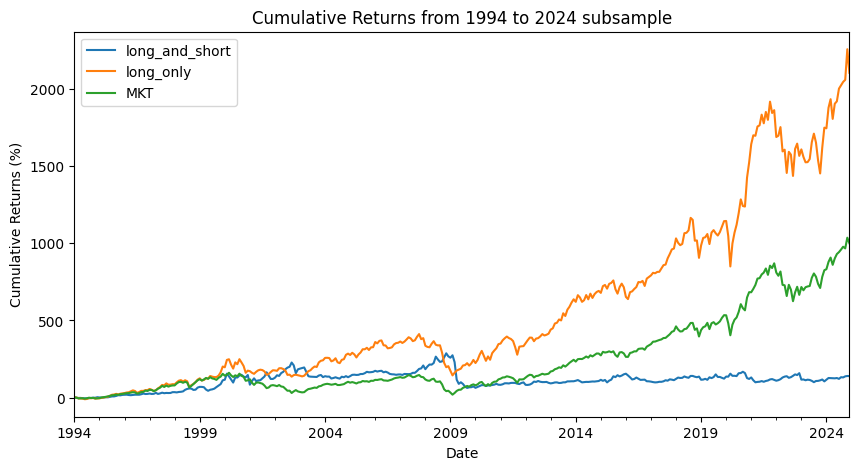

In [8]:
# Plot cumulative returns from 1994 to 2024
fig, ax = plt.subplots(figsize=(10,5))

# cumprod of momentum portfolios
# [long-only, long-short, market]
(100 * ((1 + temp[df_momentum_cols + ['MKT']].loc['1994':'2024']).cumprod() -1 )).plot(ax=ax)
ax.set_ylabel('Cumulative Returns (%)')
ax.set_title('Cumulative Returns from 1994 to 2024 subsample')

# 2.3.
Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

## (a)
Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2023.

## (b)
Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

## (c)
Should AQR’s retail product consider using a 1-decile or 5-decile construction?

## (d)
Does 
 have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

# 2.4.
Does implementing momentum require trading lots of small stocks– thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

## (a)
Fill out Table 4 over the sample 1994-2024.

## (b)
Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

# 2.5.
In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?